In [2]:
!pip install pytorch-ignite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 22.9 MB/s eta 0:00:00


In [4]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers
import time

In [5]:
DATA_DIR = './data'

IMAGE_SIZE = 32

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 32
EPOCHS = 50

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1

validation_split = 0.1

In [6]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


In [7]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [8]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:13<00:00, 12809973.95it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

In [10]:
class Residual(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.residual = nn.Sequential(*layers)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return x + self.gamma * self.residual(x)

In [11]:
class GlobalAvgPool(nn.Module):
    def forward(self, x):
        return x.mean(dim=-2)

In [32]:
class ShiftedWindowAttention(nn.Module):
    def __init__(self, dim, head_dim, shape, window_size, shift_size=0):
        super().__init__()
        self.heads = dim // head_dim
        self.head_dim = head_dim
        self.scale = head_dim**-0.5

        self.shape = shape
        self.window_size = window_size
        self.shift_size = shift_size

        self.to_qkv = nn.Linear(dim, dim * 3)
        self.unifyheads = nn.Linear(dim, dim)

        self.pos_enc = nn.Parameter(torch.Tensor(self.heads, (2 * window_size - 1)**2))
        self.register_buffer("relative_indices", self.get_indices(window_size))

        if shift_size > 0:
            self.register_buffer("mask", self.generate_mask(shape, window_size, shift_size))


    def forward(self, x):
        shift_size, window_size = self.shift_size, self.window_size

        # 1. 윈도우 분할
        x = self.to_windows(x, self.shape, window_size, shift_size) # partition into windows

        # self attention
        # 2. 각 윈도우 self attention
        # q, k, v로 분리 qkv = (batch_size, heads, 3, head_dim)
        qkv = self.to_qkv(x).unflatten(-1, (3, self.heads, self.head_dim)).transpose(-2, 1)
        queries, keys, values = qkv.unbind(dim=2)

        # query 와 key의 내적 대신에 유클리드 거리를 이용한 유사도 이용
        queries_extended = queries.unsqueeze(3)
        keys_extended = keys.unsqueeze(2)
        att = torch.sqrt(torch.sum((queries_extended - keys_extended)**2, dim=-1))

        # 3. 상대적 위치 인코딩 추가
        att = att * self.scale + self.get_rel_pos_enc(window_size) # add relative positon encoding

        # 4. masking
        if shift_size > 0:
            att = self.mask_attention(att)

        # 5. softmax를 취한다
        att = F.softmax(att, dim=-1)

        # 6. attention 값과 value를 곱한다
        x = att @ values
        x = x.transpose(1, 2).contiguous().flatten(-2, -1) # move head back
        x = self.unifyheads(x)

        # 7. 윈도우 병합
        x = self.from_windows(x, self.shape, window_size, shift_size) # undo partitioning into windows
        return x


    def to_windows(self, x, shape, window_size, shift_size):
        x = x.unflatten(1, shape)
        if shift_size > 0:
            x = x.roll((-shift_size, -shift_size), dims=(1, 2))
        x = self.split_windows(x, window_size)
        return x


    def from_windows(self, x, shape, window_size, shift_size):
        x = self.merge_windows(x, shape, window_size)
        if shift_size > 0:
            x = x.roll((shift_size, shift_size), dims=(1, 2))
        x = x.flatten(1, 2)
        return x

    # 불필요한 계산을 줄이기 위해 mask 적용
    def mask_attention(self, att):
        num_win = self.mask.size(1)
        att = att.unflatten(0, (att.size(0) // num_win, num_win))
        att = att.masked_fill(self.mask, float('-inf'))
        att = att.flatten(0, 1)
        return att

    # 상대적 위치 인코딩
    def get_rel_pos_enc(self, window_size):
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.pos_enc.gather(-1, indices) #위치 인코딩 값 저장
        rel_pos_enc = rel_pos_enc.unflatten(-1, (window_size**2, window_size**2))
        return rel_pos_enc


    # For explanation of mask regions see Figure 4 in the article
    @staticmethod
    def generate_mask(shape, window_size, shift_size):
        region_mask = torch.zeros(1, *shape, 1)
        slices = [slice(0, -window_size), slice(-window_size, -shift_size), slice(-shift_size, None)]

        region_num = 0
        for i in slices:
            for j in slices:
                region_mask[:, i, j, :] = region_num
                region_num += 1

        mask_windows = ShiftedWindowAttention.split_windows(region_mask, window_size).squeeze(-1)
        diff_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        mask = diff_mask != 0
        mask = mask.unsqueeze(1).unsqueeze(0) # add heads and batch dimension
        return mask


    @staticmethod
    def split_windows(x, window_size):
        n_h, n_w = x.size(1) // window_size, x.size(2) // window_size
        x = x.unflatten(1, (n_h, window_size)).unflatten(-2, (n_w, window_size)) # split into windows
        x = x.transpose(2, 3).flatten(0, 2) # merge batch and window numbers
        x = x.flatten(-3, -2)
        return x


    @staticmethod
    def merge_windows(x, shape, window_size):
        n_h, n_w = shape[0] // window_size, shape[1] // window_size
        b = x.size(0) // (n_h * n_w)
        x = x.unflatten(1, (window_size, window_size))
        x = x.unflatten(0, (b, n_h, n_w)).transpose(2, 3) # separate batch and window numbers
        x = x.flatten(1, 2).flatten(-3, -2) # merge windows
        return x


    @staticmethod
    def get_indices(window_size):
        x = torch.arange(window_size, dtype=torch.long)

        y1, x1, y2, x2 = torch.meshgrid(x, x, x, x, indexing='ij')
        indices = (y1 - y2 + window_size - 1) * (2 * window_size - 1) + x1 - x2 + window_size - 1
        indices = indices.flatten()

        return indices

In [33]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, mult=4):
        hidden_dim = dim * mult
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

In [34]:
class TransformerBlock(nn.Sequential):
    def __init__(self, dim, head_dim, shape, window_size, shift_size=0, p_drop=0.):
        super().__init__(
            Residual(
                nn.LayerNorm(dim),
                ShiftedWindowAttention(dim, head_dim, shape, window_size, shift_size),
                nn.Dropout(p_drop)
            ),
            Residual(
                nn.LayerNorm(dim),
                FeedForward(dim),
                nn.Dropout(p_drop)
            )
        )

In [35]:
class PatchMerging(nn.Module):
    def __init__(self, in_dim, out_dim, shape):
        super().__init__()
        self.shape = shape
        self.norm = nn.LayerNorm(4 * in_dim)
        self.reduction = nn.Linear(4 * in_dim, out_dim, bias=False)

    def forward(self, x):
        x = x.unflatten(1, self.shape).movedim(-1, 1)
        x = F.unfold(x, kernel_size=2, stride=2).movedim(1, -1)

        x = self.norm(x)
        x = self.reduction(x)
        return x

In [36]:
class Stage(nn.Sequential):
    def __init__(self, num_blocks, in_dim, out_dim, head_dim, shape, window_size, p_drop=0.):
        if out_dim != in_dim:
            layers = [PatchMerging(in_dim, out_dim, shape)]
            shape = (shape[0] // 2, shape[1] // 2)
        else:
            layers = []

        shift_size = window_size // 2
        layers += [TransformerBlock(out_dim, head_dim, shape, window_size, 0 if (num % 2 == 0) else shift_size,
                                    p_drop) for num in range(num_blocks)]

        super().__init__(*layers)

In [37]:
class StageStack(nn.Sequential):
    def __init__(self, num_blocks_list, dims, head_dim, shape, window_size, p_drop=0.):
        layers = []
        in_dim = dims[0]
        for num, out_dim in zip(num_blocks_list, dims[1:]):
            layers.append(Stage(num, in_dim, out_dim, head_dim, shape, window_size, p_drop))
            if in_dim != out_dim:
                shape = (shape[0] // 2, shape[1] // 2)
                in_dim = out_dim

        super().__init__(*layers)

In [38]:
class ToPatches(nn.Module):
    def __init__(self, in_channels, dim, patch_size):
        super().__init__()
        self.patch_size = patch_size
        patch_dim = in_channels * patch_size**2
        self.proj = nn.Linear(patch_dim, dim)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        x = F.unfold(x, kernel_size=self.patch_size, stride=self.patch_size).movedim(1, -1)
        x = self.proj(x)
        x = self.norm(x)
        return x

In [39]:
class AddPositionEmbedding(nn.Module):
    def __init__(self, dim, num_patches):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.Tensor(num_patches, dim))

    def forward(self, x):
        return x + self.pos_embedding

In [40]:
class ToEmbedding(nn.Sequential):
    def __init__(self, in_channels, dim, patch_size, num_patches, p_drop=0.):
        super().__init__(
            ToPatches(in_channels, dim, patch_size),
            AddPositionEmbedding(dim, num_patches),
            nn.Dropout(p_drop)
        )

In [41]:
class Head(nn.Sequential):
    def __init__(self, dim, classes, p_drop=0.):
        super().__init__(
            nn.LayerNorm(dim),
            nn.GELU(),
            GlobalAvgPool(),
            nn.Dropout(p_drop),
            nn.Linear(dim, classes)
        )

In [42]:
class SwinTransformer(nn.Sequential):
    def __init__(self, classes, image_size, num_blocks_list, dims, head_dim, patch_size, window_size,
                 in_channels=3, emb_p_drop=0., trans_p_drop=0., head_p_drop=0.):
        reduced_size = image_size // patch_size
        shape = (reduced_size, reduced_size)
        num_patches = shape[0] * shape[1]

        super().__init__(
            ToEmbedding(in_channels, dims[0], patch_size, num_patches, emb_p_drop),
            StageStack(num_blocks_list, dims, head_dim, shape, window_size, trans_p_drop),
            Head(dims[-1], classes, head_p_drop)
        )
        self.reset_parameters()

    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.)
                nn.init.zeros_(m.bias)
            elif isinstance(m, AddPositionEmbedding):
                nn.init.normal_(m.pos_embedding, mean=0.0, std=0.02)
            elif isinstance(m, ShiftedWindowAttention):
                nn.init.normal_(m.pos_enc, mean=0.0, std=0.02)
            elif isinstance(m, Residual):
                nn.init.zeros_(m.gamma)

    def separate_parameters(self):
        parameters_decay = set()
        parameters_no_decay = set()
        modules_weight_decay = (nn.Linear, )
        modules_no_weight_decay = (nn.LayerNorm,)

        for m_name, m in self.named_modules():
            for param_name, param in m.named_parameters():
                full_param_name = f"{m_name}.{param_name}" if m_name else param_name

                if isinstance(m, modules_no_weight_decay):
                    parameters_no_decay.add(full_param_name)
                elif param_name.endswith("bias"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, Residual) and param_name.endswith("gamma"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, AddPositionEmbedding) and param_name.endswith("pos_embedding"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, ShiftedWindowAttention) and param_name.endswith("pos_enc"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, modules_weight_decay):
                    parameters_decay.add(full_param_name)

        # sanity check
        assert len(parameters_decay & parameters_no_decay) == 0
        assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

        return parameters_decay, parameters_no_decay

In [43]:
model = SwinTransformer(NUM_CLASSES, IMAGE_SIZE,
                        num_blocks_list=[4, 4], dims=[128, 128, 256],
                        head_dim=32, patch_size=2, window_size=4,
                        emb_p_drop=0., trans_p_drop=0., head_p_drop=0.3)

In [44]:
model.to(DEVICE);

In [45]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 4,124,362


In [46]:
def get_optimizer(model, learning_rate, weight_decay):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    parameters_decay, parameters_no_decay = model.separate_parameters()

    optim_groups = [
        {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
    ]
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer

In [47]:
loss = nn.CrossEntropyLoss()
optimizer = get_optimizer(model, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)
history = defaultdict(list)

In [48]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)

    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)

    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

In [49]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/50 - train: loss 1.994; val: loss 1.961 accuracy 0.260
2/50 - train: loss 1.763; val: loss 1.773 accuracy 0.341
3/50 - train: loss 1.522; val: loss 1.490 accuracy 0.451
4/50 - train: loss 1.388; val: loss 1.303 accuracy 0.529
5/50 - train: loss 1.265; val: loss 1.205 accuracy 0.561
6/50 - train: loss 1.180; val: loss 1.152 accuracy 0.581
7/50 - train: loss 1.127; val: loss 1.104 accuracy 0.605
8/50 - train: loss 1.073; val: loss 1.034 accuracy 0.631
9/50 - train: loss 1.018; val: loss 0.991 accuracy 0.652
10/50 - train: loss 0.985; val: loss 0.992 accuracy 0.659
11/50 - train: loss 0.931; val: loss 0.920 accuracy 0.684
12/50 - train: loss 0.890; val: loss 0.927 accuracy 0.682
13/50 - train: loss 0.868; val: loss 0.833 accuracy 0.704
14/50 - train: loss 0.891; val: loss 0.833 accuracy 0.715
15/50 - train: loss 0.820; val: loss 0.818 accuracy 0.719
16/50 - train: loss 0.778; val: loss 0.816 accuracy 0.722
17/50 - train: loss 0.777; val: loss 0.772 accuracy 0.734
18/50 - train: loss 0.7

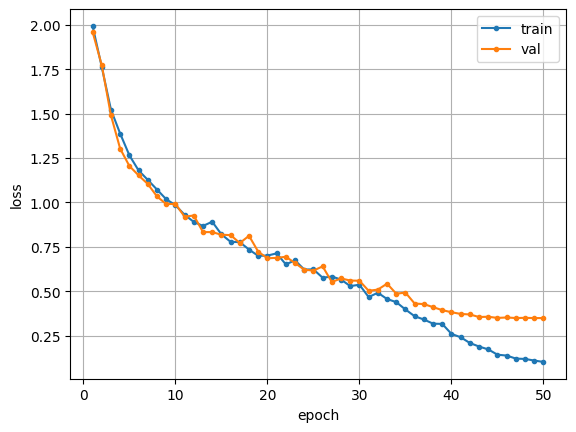

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['train loss']) + 1)
ax.plot(xs, history['train loss'], '.-', label='train')
ax.plot(xs, history['val loss'], '.-', label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
ax.grid()
plt.show()

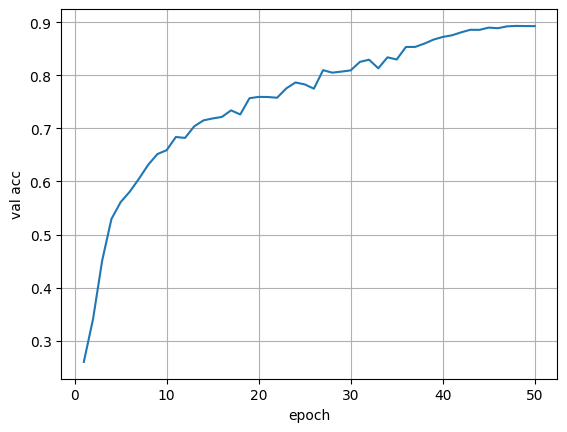

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['val acc']) + 1)
ax.plot(xs, history['val acc'], '-')
ax.set_xlabel('epoch')
ax.set_ylabel('val acc')
ax.grid()
plt.show()